### Datasets and inputs
The entire Amazon Bin Image Dataset contains over 500,000 images. A smaller subset of 10,441 has been provided for the purposes of this project, with class labels and file names given in the file `json_list.json`. A quick analysis of the latter yields the class distributions below.

In [2]:
import os
import json
import matplotlib.pyplot as plt
import pandas as pd 

In [3]:
with open('file_list.json') as f:
    data = json.load(f)

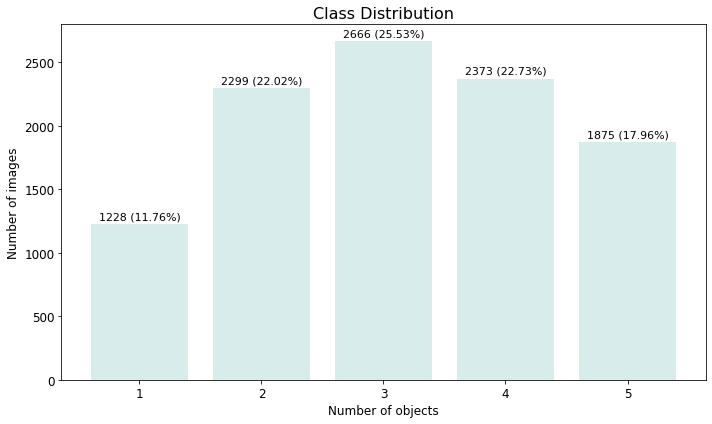

In [4]:
# Calculate the count of values in each class
class_counts = {key: len(values) for key, values in data.items()}

# Convert the dictionary into separate lists for keys and values
class_names = list(class_counts.keys())
counts = list(class_counts.values())

# Calculate the total number of values in the dataset
total_values = sum(class_counts.values())

# Calculate the percentage of each class and format it as a string
percentages = [(count / total_values) * 100 for count in counts]
percentage_labels = [f'{count} ({percentage:.2f}%)' for count, percentage in zip(counts, percentages)]

# Create the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(class_names, counts, alpha=0.15, color='teal')

plt.xlabel('Number of objects', fontsize=12)
plt.ylabel('Number of images', fontsize=12)
plt.title('Class Distribution', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add the percentage labels to the bars
for bar, label in zip(bars, percentage_labels):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 20, label,
             ha='center', va='bottom', color='black', fontsize=11)


plt.tight_layout()

# # Save the figure
# plt.savefig('class_distribution.png')

plt.show()


The classes are imbalanced, with a relative majority of images (\~26%) containing three images and a minority (\~12%) containing just one image. That said, given that the most prevalent class is only a little over twice as common as the rarest, we assume that this will not affect learning significantly and therefore omit a preprocessing step wherein we balance the classes somehow, e.g. via over- or undersampling. Once the pipeline is built and assessed, we could take a look at how well the model is classifying each class and add this in later to optimise performance if necessary.

As part of the initial data preparation we will split the data into sets according to a 60:20:20 training:validation:testing split. This will leave about 700 images in the training set of the  least-represented class, which <a href="https://datascience.stackexchange.com/questions/90562/how-much-imbalance-in-a-training-set-is-a-problem#:~:text=There%20is%20no%20agreement%2C%20or,would%20only%20be%20marginally%20unbalanced%2C" target="_blank" rel="noopener">should be enough to get okay results given that we are using transfer learning.</a>

## Data Preparation

The metadata for our training set is in `file_list.json`. Running the cell below downloads and organises the data into training, validation and testing folders, each of which further subdivides the folders depending on the number of objects in the images. 

In [4]:
! python ./scripts/download_and_arrange_data.py

100%|███████████████████████████████████████| 1122/1122 [09:44<00:00,  1.92it/s]


We can now confirm the class split between each of the sets.

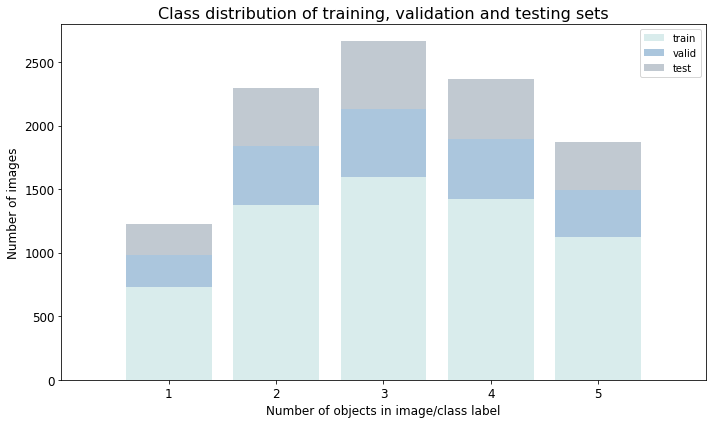

We have 10426 images in total and these are split as follows:

	- Training: 6246 (60%);
	- Validation: 2090 (20%);
	- Testing: 2090 (20%);


In [5]:
def file_locs_and_labels(root_dir):
    """
    Returns a dataframe of names and class labels of all images in root_dir.
    """
    # List of subfolders sorted by class label, omitting secret files
    sub_folders = sorted((f for f in os.listdir(root_dir) \
                          if not f.startswith(".")), key=str.lower)
    
    # List of class labels
    labels = [int(name.split(".")[0]) for name in sub_folders]
    
    data = []
    
    for sub_f, label in zip(sub_folders, labels):
        for _, __, f in os.walk(os.path.join(root_dir, sub_f)):
            for file in f:
                if file.endswith(".jpg"):
                    data.append((os.path.join(sub_f, file), label))

    df = pd.DataFrame(data, columns=['file_name', 'label'])
    
    return df

def counts_and_labels(df):
    """
    Calculates the class cardinalities.
    """
    counts_df = df.groupby('label').count().reset_index()\
    .rename(columns={'file_name': 'count'})

    class_counts = counts_df['count'].values
    class_labels = counts_df['label'].values
    
    return class_labels, class_counts

subdirs = ['train', 'valid', 'test']
dfs = []

# Make dataframes of names and labels of files in each folder
for subdir in subdirs:
    root = "./binImages/" + subdir
    dfs.append(file_locs_and_labels(root))


# Create the bar plot
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed

class_labels, class_counts_train = counts_and_labels(dfs[0])
class_counts_valid = counts_and_labels(dfs[1])[1]
class_counts_test = counts_and_labels(dfs[2])[1]

bars_train = plt.bar(class_labels, class_counts_train, alpha=0.15, label='train', color='teal')
bars_valid = plt.bar(class_labels, class_counts_valid, bottom=class_counts_train, alpha=0.45, label='valid', color='steelblue')
bars_test = plt.bar(class_labels, class_counts_test, bottom=class_counts_train + class_counts_valid, alpha=0.45, label='test', color='lightslategrey')


plt.xlabel('Number of objects in image/class label', fontsize=12)
plt.ylabel('Number of images', fontsize=12)
plt.title('Class distribution of training, validation and testing sets', fontsize=16)
plt.xticks(range(1, 6), fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([0, 6])
plt.legend()

plt.tight_layout()
plt.savefig('class_distribution.png')

plt.show()

nums = [dfs[i].shape[0] for i in range(len(dfs))]
total = sum(nums)

print(f"We have {total} images in total and these are split as follows:\n\n\
\t- Training: {nums[0]} ({round(nums[0]/total * 100)}%);\
\n\t- Validation: {nums[1]} ({round(nums[1]/total * 100)}%);\
\n\t- Testing: {nums[2]} ({round(nums[2]/total * 100)}%);")


We can visualise some of the images as follows.

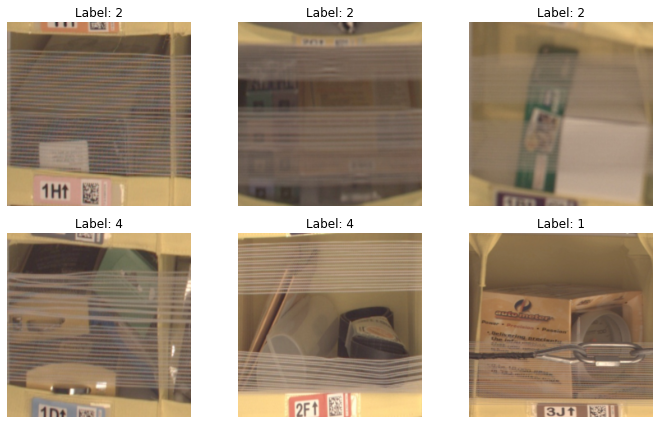

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import random


fig, ax = plt.subplots(2, 3, figsize=(10, 6))

root_dir = "./binImages/train"

# Pick a random image index
idx = random.choice(range(0, dfs[0].shape[0]))
# Two rows, three columns
for i in range(2):
    for j in range(3):
        
        label = dfs[0].label[idx]
        file_path = os.path.join(root_dir, dfs[0].file_name[idx])
        
        # Load the image
        image = Image.open(file_path)
        
        # Resize and convert to tensor
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])
        image = transform(image)
        
        # Permute the data for matplotlib
        ax[i,j].imshow(image.permute(1, 2, 0))
        ax[i,j].set_title(f"Label: {label}")
        ax[i,j].axis('off')
        # Pick a different image
        idx = random.choice(range(0, dfs[0].shape[0]))
        
plt.tight_layout()
plt.savefig('sample_images.png')
plt.show()

Examining the sample images, we see that, due to contrast, resolution and occlusion, in at least some of the cases it is not entirely straightforward for a human to see exactly how many objects there are; we thus anticipate that this could potentially be a difficult task to obtain good accuracy on.

## Preprocessing

### Normalisation

It's standard practice in machine learning to standardize the training dataset as this lessens the impact of outliers on gradient calculations, as well as speeding convergence. 

The script `normalize_local.py` calculates the mean and standard deviation of the training images to be [0.5239, 0.4427, 0.3532] and 
[0.1602, 0.1405, 0.1062], respectively. Below is an example of an image pre- and post standardisation.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


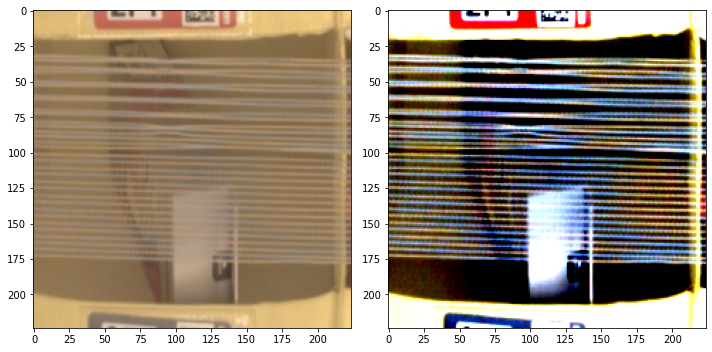

In [16]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 6))

root_dir = "./binImages/train"

# Pick an image at random
idx = 16

label = dfs[0].label[idx]
file_path = os.path.join(root_dir, dfs[0].file_name[idx])

# Load the image
image = Image.open(file_path)

# Resize and convert to tensor
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
img = transform(image)

# Resize and convert to tensor
transform_norm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5239, 0.4427, 0.3532],
                        std=[0.1602, 0.1405, 0.1062])
])
img_norm = transform_norm(image)

# Permute the data for matplotlib
for i, im in enumerate([img, img_norm]):
    ax[i].imshow(im.permute(1, 2, 0))
        
plt.tight_layout()
plt.savefig('normalized.png')
plt.show()

### Data augmentation

Additional preprocessing was also applied on some of the training runs. This can be used to create additional data but in our case we simply use it to add some noise to the dataset to try to mitigate overfitting. Below is an example of an augmented image.

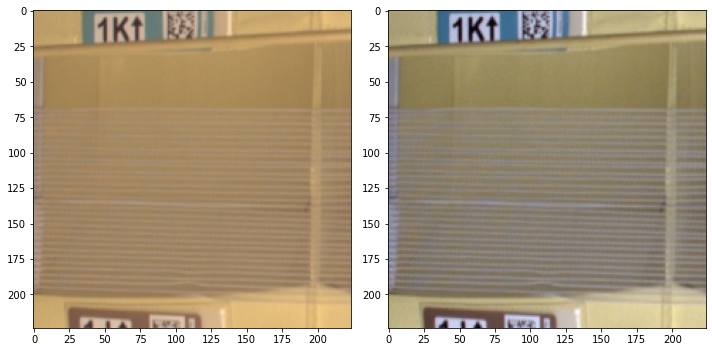

In [17]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 6))

root_dir = "./binImages/train"

# Pick an image at random
idx = 160

label = dfs[0].label[idx]
file_path = os.path.join(root_dir, dfs[0].file_name[idx])

# Load the image
image = Image.open(file_path)

# Resize and convert to tensor
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
img = transform(image)

# Resize and convert to tensor
transform_aug = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomAutocontrast(p=0.999),
    transforms.ToTensor()
])
img_aug = transform_aug(image)

# Permute the data for matplotlib
for i, im in enumerate([img, img_aug]):
    ax[i].imshow(im.permute(1, 2, 0))
        
plt.tight_layout()
plt.savefig('augmented.png')
plt.show()